In [4]:
import re
import pandas as pd
from collections import defaultdict

# Function to extract data from the structure info file and group by space group
def extract_structure_data(file_path, functional_name, grouped_data, energy_data):
    with open(file_path, 'r') as file:
        data = file.read()
    
    # Split data by separators
    phases = data.split('-----------------------------------------')
    
    for phase in phases:
        # Extract space group, lattice constants, angles, and energy (E0)
        space_group_match = re.search(r'International:\s*(\S+)', phase)
        lattice_constants_match = re.search(r'Lattice Constants:\s*([\d\.]+\s+[\d\.]+\s+[\d\.]+)', phase)
        lattice_angles_match = re.search(r'Lattice Angles:\s*([\d\.]+\s+[\d\.]+\s+[\d\.]+)', phase)
        energy_match = re.search(r'E0=\s*([-\d\.E+]+)', phase)  # Extracting the E0 value
        
        if space_group_match and lattice_constants_match and lattice_angles_match and energy_match:
            space_group = space_group_match.group(1)
            lattice_constants = list(map(float, lattice_constants_match.group(1).split()))
            lattice_angles = list(map(float, lattice_angles_match.group(1).split()))
            energy = float(energy_match.group(1))
            
            # Store the data in the grouped_data dictionary for lattice constants and angles
            if space_group not in grouped_data:
                grouped_data[space_group] = {'PBE': [], 'PBESol': [], 'HSE': [], 'IVDW': []}
            
            grouped_data[space_group][functional_name] = lattice_constants + lattice_angles
            
            # Store the energy in the energy_data dictionary for the space group
            if space_group not in energy_data:
                energy_data[space_group] = {'PBE': None, 'PBESol': None, 'HSE': None, 'IVDW': None}
            
            energy_data[space_group][functional_name] = energy

# Function to save the grouped data into a CSV file for lattice constants and angles
def save_to_csv(file_paths, output_csv):
    grouped_data = defaultdict(lambda: {'PBE': [], 'PBESol': [], 'HSE': [], 'IVDW': []})
    energy_data = defaultdict(lambda: {'PBE': None, 'PBESol': None, 'HSE': None, 'IVDW': None})
    
    # Extract data from each file
    for file_path, functional_name in file_paths:
        extract_structure_data(file_path, functional_name, grouped_data, energy_data)
    
    # Prepare the data for the CSV file for structure data
    all_data = []
    headers = ["Space Group", 
               "PBE a", "PBE b", "PBE c", "PBE alpha", "PBE beta", "PBE gamma", 
               "PBESol a", "PBESol b", "PBESol c", "PBESol alpha", "PBESol beta", "PBESol gamma", 
               "HSE a", "HSE b", "HSE c", "HSE alpha", "HSE beta", "HSE gamma",
               "IVDW a", "IVDW b", "IVDW c", "IVDW alpha", "IVDW beta", "IVDW gamma"]
    
    # Organize data for each space group
    for space_group, data in grouped_data.items():
        row = [space_group]
        
        for functional in ['PBE', 'PBESol', 'HSE', 'IVDW']:
            if data[functional]:
                row.extend(data[functional])
            else:
                row.extend([float('nan')] * 6)  # 6 columns for lattice constants and angles
        
        all_data.append(row)
    
    # Save to CSV for structure data
    df = pd.DataFrame(all_data, columns=headers)
    df.to_csv(output_csv, index=False)
    
    # Prepare the data for the CSV file for energy data
    energy_rows = []
    energy_headers = ["Space Group", "PBE Energy", "PBESol Energy", "HSE Energy", "IVDW Energy"]
    
    # Organize energy data for each space group
    for space_group, energies in energy_data.items():
        energy_row = [space_group]
        
        for functional in ['PBE', 'PBESol', 'HSE', 'IVDW']:
            energy_row.append(energies[functional] if energies[functional] is not None else float('nan'))
        
        energy_rows.append(energy_row)
    
    # Convert to DataFrame for energy data
    energy_df = pd.DataFrame(energy_rows, columns=energy_headers)
    
    # Calculate the relative energies by subtracting the minimum energy in each column
    for functional in ['PBE', 'PBESol', 'HSE', 'IVDW']:
        min_energy = energy_df[functional + " Energy"].min()
        
        # Print the space group corresponding to the minimum energy
        min_energy_space_group = energy_df.loc[energy_df[functional + " Energy"] == min_energy, "Space Group"].values[0]
        print(f"Minimum energy for {functional}: {min_energy}, corresponding to space group: {min_energy_space_group}")
        
        # Subtract the minimum energy from all values in that column
        energy_df[functional + " Energy"] = energy_df[functional + " Energy"] - min_energy
    
    # Sort the energy data by PBE Energy
    energy_df = energy_df.sort_values(by="PBE Energy")
    
    # Save to CSV for relative energy data
    energy_df.to_csv("different_xc_energy_data.csv", index=False)

# File paths and corresponding functional names
file_paths = [
    ('HSE_structure_info.txt', 'HSE'),
    ('PBE_structure_info.txt', 'PBE'),
    ('PBESol_structure_info.txt', 'PBESol'),
    ('IVDW_structure_info.txt', 'IVDW')
]

# Output CSV file for structure data
output_csv = 'structure_data_grouped_.csv'
save_to_csv(file_paths, output_csv)


Minimum energy for PBE: -115.13208, corresponding to space group: P2_1/c
Minimum energy for PBESol: -120.29353, corresponding to space group: P2_1/c
Minimum energy for HSE: -139.31114, corresponding to space group: P2_1/c
Minimum energy for IVDW: -118.10175, corresponding to space group: P2_1/c


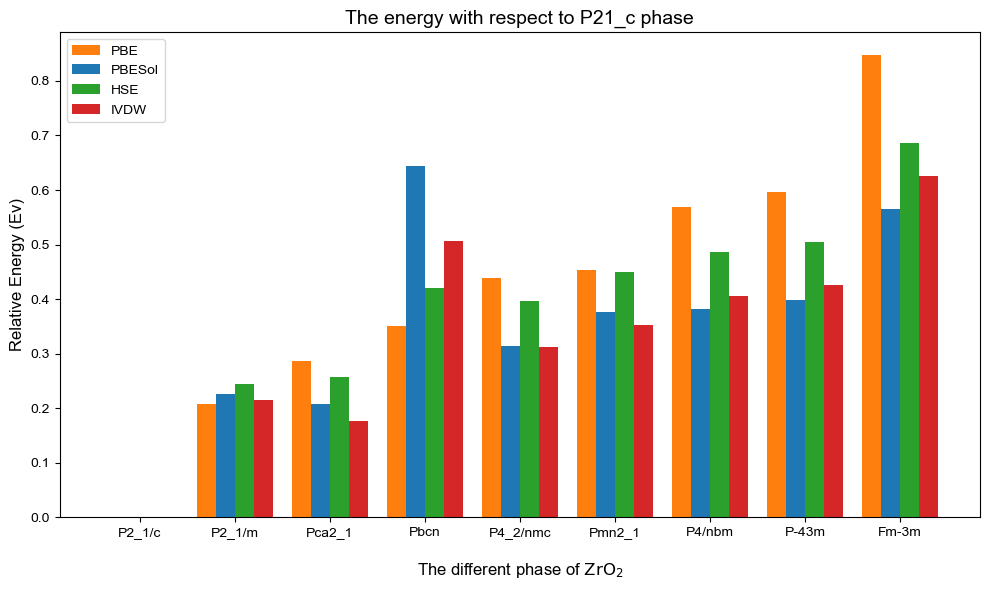

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib



matplotlib.rcParams['font.family'] = 'Arial'

def plot_comparison_bar_chart(csv_file):
    """
    This function reads a CSV file and plots a grouped bar chart comparing values
    from the second to fourth columns across different phases.
    
    Parameters:
    csv_file (str): Path to the input CSV file.
    """
    # Read the CSV file
    data = pd.read_csv(csv_file)
    
    # Extract data columns
    phases = data['Space Group']  # First column as phase labels
    pbe = data['PBE Energy']  # Second column (PBE)
    pbesol = data['PBESol Energy']  # Third column (PBESol)
    hse = data['HSE Energy']  # Fourth column (HSE)
    ivdw = data['IVDW Energy']  # Fifth column (IVDW)
    
    # Set the position for each group of bars
    x = np.arange(len(phases))  # Position of each group of bars
    width = 0.2  # Width of each bar
    
    # Create a figure and axis for the plot
    fig, ax = plt.subplots(figsize=(10, 6))
    
    # Plot each set of bars with different colors
    ax.bar(x - 1.5 * width, pbe, width, label='PBE', color='tab:orange')
    ax.bar(x - 0.5 * width, pbesol, width, label='PBESol', color='tab:blue')
    ax.bar(x + 0.5 * width, hse, width, label='HSE', color='tab:green')
    ax.bar(x + 1.5 * width, ivdw, width, label='IVDW', color='tab:red')
    
    # Set axis labels and title
    ax.set_xlabel(r'The different phase of $\text{ZrO}_2$', fontsize=12, labelpad=15)
    ax.set_ylabel('Relative Energy (Ev)', fontsize=12)
    ax.set_title('The energy with respect to P21_c phase', fontsize=14)
    
    # Set x-axis ticks and labels (phase names)
    ax.set_xticks(x)
    ax.set_xticklabels(phases, rotation=0, ha='center')
    
    # Add legend to the plot
    # ax.legend(title="Functional", fontsize=10)
    ax.legend(fontsize=10)
    
    # Adjust layout to prevent clipping of labels
    plt.tight_layout()

    # save the plot
    plt.savefig('comparison_bar_chart.png', dpi=600)
    
    # Show the plot
    plt.show()

# Example usage
csv_file = 'different_xc_energy_data.csv'  # Replace with your CSV file path
plot_comparison_bar_chart(csv_file)


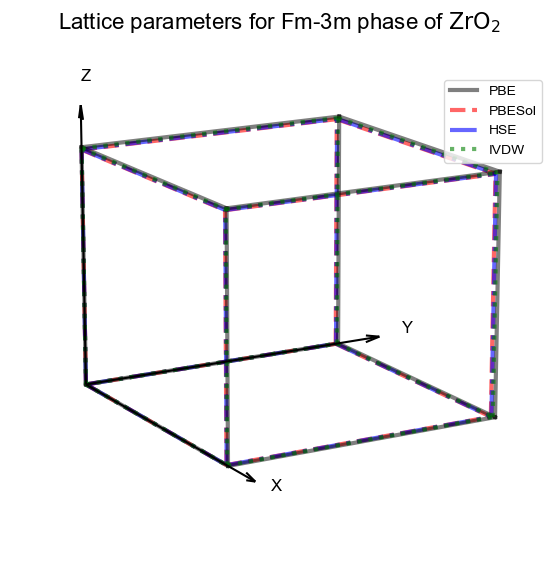

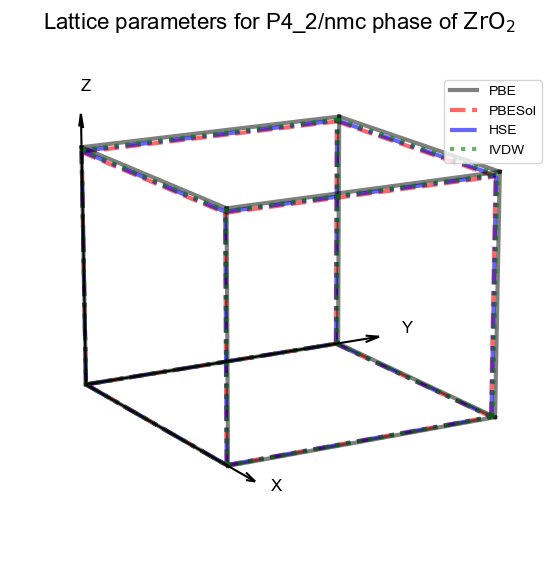

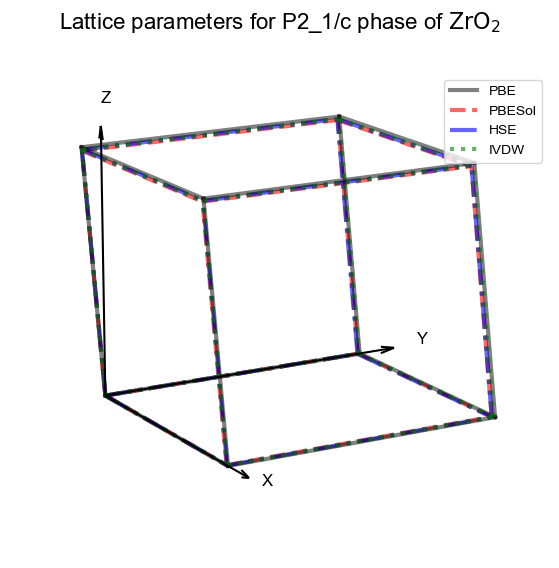

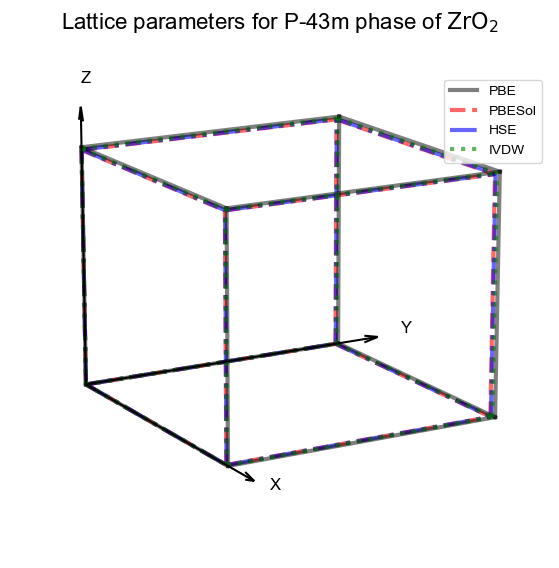

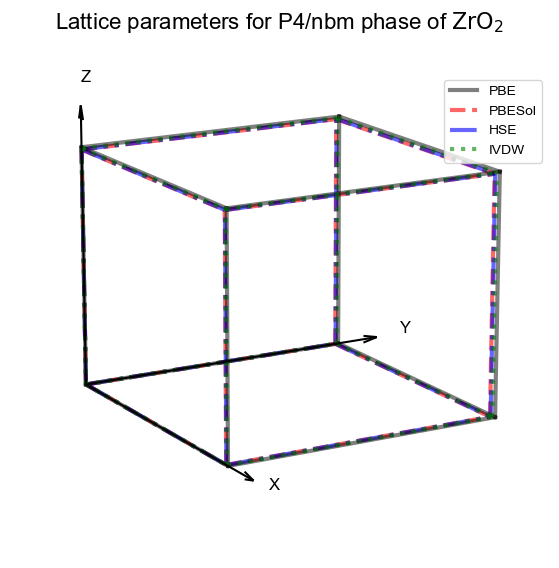

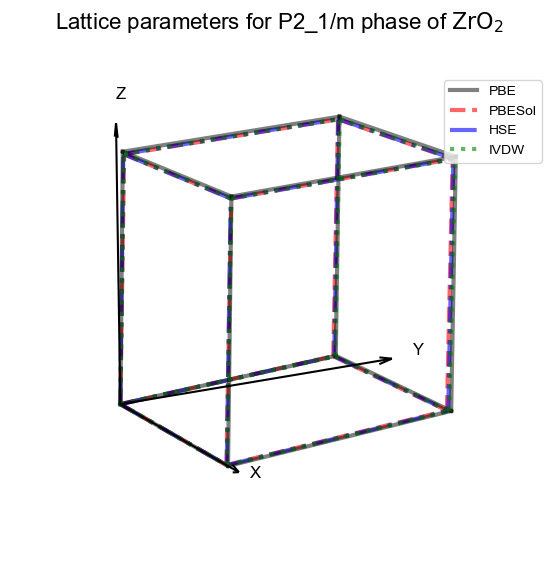

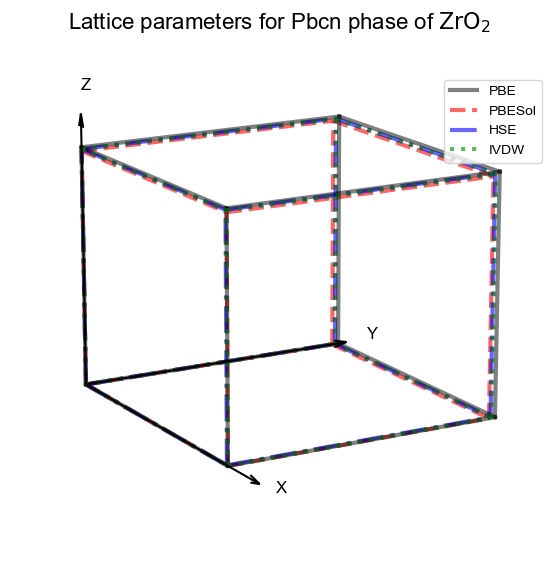

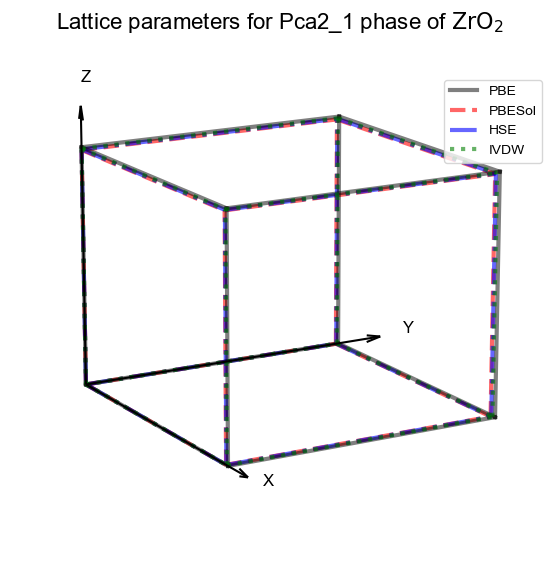

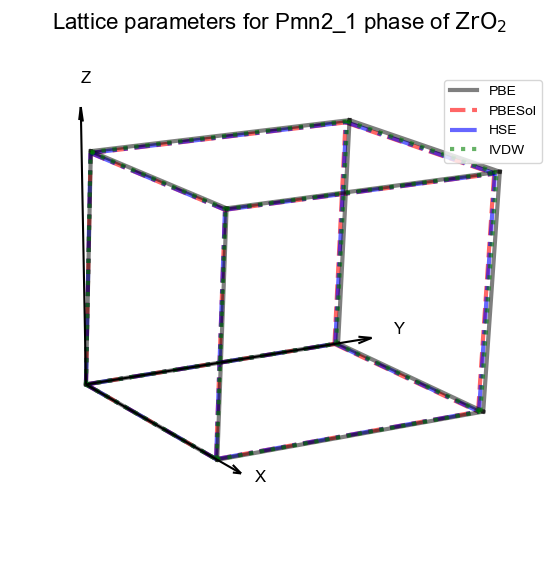

In [9]:
import matplotlib.pyplot as plt
import matplotlib
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import pandas as pd
import re

matplotlib.rcParams['font.family'] = 'Arial'

def sanitize_filename(filename):
    return re.sub(r'[\/:*?"<>|]', '__', filename)

# Function to plot the cubic structure for each phase
def plot_structure(df):
    space_groups = df['Space Group'].unique()
    
    # Colors for different functionals and line styles
    functional_colors = {'PBE': 'black', 'PBESol': 'red', 'HSE': 'blue', 'IVDW': 'green'}
    line_styles = {'PBE': '-', 'PBESol': '--', 'HSE': '-.', 'IVDW': ':'}
    functional_alpha = {'PBE': 0.5, 'PBESol': 0.6, 'HSE': 0.6, 'IVDW': 0.6}
    
    # # Colors for different functionals and line styles
    # functional_colors = {'PBE': '#2ca02c', 'PBESol': '#ff7f0e', 'HSE': '#1f77b4'}
    # line_styles = {'PBE': '-', 'PBESol': '--', 'HSE': '-.'}
    # functional_alpha = {'PBE': 0.5, 'PBESol': 0.5, 'HSE': 0.5}

    # # Add markers for clarity
    # markers = {'PBE': 'o', 'PBESol': '^', 'HSE': 's'}


    # Loop over each space group
    for space_group in space_groups:
        fig = plt.figure(figsize=(10, 7))
        ax = fig.add_subplot(111, projection='3d')  # No frame_on for 3D axes
        
        # Remove the frame (border) by setting the spines to invisible
        for spine in ax.spines.values():
            spine.set_visible(False)
        
        # Filter data by space group
        space_group_data = df[df['Space Group'] == space_group]
        
        # Loop through the data for each functional
        for functional in ['PBESol', 'HSE','PBE', 'IVDW']:
            # Get the columns corresponding to the functional
            a_col = f"{functional} a"
            b_col = f"{functional} b"
            c_col = f"{functional} c"
            alpha_col = f"{functional} alpha"
            beta_col = f"{functional} beta"
            gamma_col = f"{functional} gamma"
            
            for _, row in space_group_data.iterrows():
                # Extract lattice constants and angles
                a, b, c = row[a_col], row[b_col], row[c_col]
                alpha, beta, gamma = row[alpha_col], row[beta_col], row[gamma_col]
                
                # Check if any value is NaN
                if any(np.isnan([a, b, c, alpha, beta, gamma])):
                    continue
                
                # Convert angles from degrees to radians
                alpha_rad = np.radians(alpha)
                beta_rad = np.radians(beta)
                gamma_rad = np.radians(gamma)
                
                # Define the transformation matrix for the lattice
                # Using the full formula for non-orthogonal lattice
                # A = np.array([
                #     [a, 0, 0],
                #     [b * np.cos(gamma_rad), b * np.sin(gamma_rad), 0],
                #     [c * np.cos(beta_rad), 
                #      c * (np.cos(alpha_rad) - np.cos(beta_rad) * np.cos(gamma_rad)) / np.sin(gamma_rad), 
                #      c * np.sqrt(1 - np.cos(beta_rad)**2 - (np.cos(alpha_rad) - np.cos(beta_rad) * np.cos(gamma_rad))**2 / np.sin(gamma_rad)**2)]
                # ])

                A = np.array([
                    [a, 0, 0],
                    [b * np.cos(gamma_rad), b * np.sin(gamma_rad), 0],
                    [c * np.cos(beta_rad), 
                     c * np.cos(alpha_rad) * np.sin(gamma_rad), 
                     c * np.sin(np.arccos(np.sqrt((c * np.cos(beta_rad)**2 +( c * np.cos(alpha_rad) * np.sin(gamma_rad))**2))/c))
                     ]
                ])
                # print(A)                
                
                # Generate the 8 corners of the unit cell based on the lattice matrix
                corners = []
                for i in range(2):
                    for j in range(2):
                        for k in range(2):
                            # Use the lattice matrix A to generate the points
                            point = i * A[0] + j * A[1] + k * A[2]
                            corners.append(point)
                
                corners = np.array(corners)


                lines = [
                    [corners[0], corners[1]],  # (0,0,0) -> (a,0,0)
                    [corners[0], corners[2]],  # (0,0,0) -> (0,b,0)
                    [corners[0], corners[4]],  # (0,0,0) -> (0,0,c)
                    [corners[1], corners[3]],  # (a,0,0) -> (a,b,0)
                    [corners[1], corners[5]],  # (a,0,0) -> (a,0,c)
                    [corners[2], corners[3]],  # (0,b,0) -> (a,b,0)
                    [corners[2], corners[6]],  # (0,b,0) -> (0,b,c)
                    [corners[4], corners[5]],  # (0,0,c) -> (a,0,c)
                    [corners[4], corners[6]],  # (0,0,c) -> (0,b,c)
                    [corners[5], corners[7]],  # (a,0,c) -> (a,b,c)
                    [corners[6], corners[7]],  # (0,b,c) -> (a,b,c)
                    [corners[3], corners[7]]   # (a,b,0) -> (a,b,c)
                ]

                for line in lines:
                    ax.plot([line[0][0], line[1][0]], 
                            [line[0][1], line[1][1]], 
                            [line[0][2], line[1][2]], 
                            color=functional_colors[functional], 
                            linestyle=line_styles[functional], 
                            lw=3,
                            alpha=functional_alpha[functional])

                    # midpoint = (line[0] + line[1]) / 2
                    # ax.scatter(midpoint[0], midpoint[1], midpoint[2], 
                    #            color=functional_colors[functional], 
                    #            marker=markers[functional], 
                    #            s=100, alpha=0.7)


        # Set the title for the plot
        ax.set_title(f"Lattice parameters for {space_group} phase of $\\text{{ZrO}}_2$", fontsize=16, y=1.05)#pad=-80
        
        # Draw orthogonal arrows indicating the positive direction of the axes
        ax.quiver(0, 0, 0, 1, 0, 0, color='black', length=6, arrow_length_ratio=0.05)
        ax.quiver(0, 0, 0, 0, 1, 0, color='black', length=6, arrow_length_ratio=0.05)
        ax.quiver(0, 0, 0, 0, 0, 1, color='black', length=6, arrow_length_ratio=0.05)


        # Label the axes
        ax.text(6.5, 0, 0, 'X', color='black', fontsize=12)
        ax.text(0, 6.5, 0, 'Y', color='black', fontsize=12)
        ax.text(0, 0, 6.5, 'Z', color='black', fontsize=12)
        
        # Set the viewing angle
        ax.view_init(elev=15, azim=-30)
        
        # Remove the grid, axis labels, and ticks
        ax.grid(False)
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_zticks([])
        ax.set_xlabel('')
        ax.set_ylabel('')
        ax.set_zlabel('')
        
        # Manually create a legend with matching colors and line styles
        handles = []
        for functional, color in functional_colors.items():
            line = plt.Line2D([0], [0], color=color, linestyle=line_styles[functional], alpha=functional_alpha[functional], lw=3)
            handles.append(line)
        
        # Show the plot with the updated legend
        ax.legend(handles, ['PBE', 'PBESol', 'HSE', 'IVDW'], loc='upper right', bbox_to_anchor=(1, 0.9))

        # Remove the axis frame
        ax.set_axis_off()

        # Save the plot as a PNG file
        filename=f"structure_{space_group}"
        filename=sanitize_filename(filename)
        plt.savefig(f"{filename}_edit.png", dpi=300, bbox_inches='tight')
        
        # Show the plot
        plt.show()


# Read the CSV file
df = pd.read_csv('structure_data_grouped_.csv')

# Plot the structures
plot_structure(df)
